<a href="https://colab.research.google.com/github/JorgeCarmona323/Macrocycle/blob/main/Dibromo_Linker_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dependencies managed via environment.yml
# Run: conda env create -f environment.yml && conda activate bro5

In [ ]:
from pathlib import Path

# DATA PATHS - update DATA_ROOT to point to your data folder
DATA_ROOT = Path("../../data")       # relative to notebook location
OUTPUT_ROOT = Path("../../outputs")

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def macrocyclize(pep_smi: str, linker_smiles: str):
    """Cyclize two peptide thiols onto a dibromo linker."""
    pep    = Chem.MolFromSmiles(pep_smi)
    linker = Chem.MolFromSmiles(linker_smiles)
    if pep is None or linker is None:
        return None

    combined = Chem.CombineMols(pep, linker)
    rw = Chem.RWMol(combined)
    pep_atom_count = pep.GetNumAtoms()

    # only look for linker bromines
    HALOGENS = {35}  # Br
    linker_carbons, halogens_to_remove = [], []

    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() in HALOGENS and atom.GetIdx() >= pep_atom_count:
            for nb in atom.GetNeighbors():
                if nb.GetAtomicNum() == 6 and nb.GetIdx() >= pep_atom_count:
                    linker_carbons.append(nb.GetIdx())
                    halogens_to_remove.append(atom.GetIdx())

    linker_carbons = list(dict.fromkeys(linker_carbons))
    if len(linker_carbons) != 2:
        return None
    c1, c2 = linker_carbons

    # two peptide thiols (S with one H)
    s_idxs = [a.GetIdx() for a in rw.GetAtoms()
              if a.GetAtomicNum() == 16 and a.GetIdx() < pep_atom_count and a.GetTotalNumHs() == 1]
    if len(s_idxs) < 2:
        return None
    s1, s2 = s_idxs[:2]

    # add S–C bonds and remove Br
    rw.AddBond(s1, c1, Chem.BondType.SINGLE)
    rw.AddBond(s2, c2, Chem.BondType.SINGLE)
    for idx in sorted(set(halogens_to_remove), reverse=True):
        rw.RemoveAtom(idx)

    mol = rw.GetMol()
    Chem.SanitizeMol(mol)
    return mol


Stapled Macrocycle SMILES: C#CCCC(=O)N[C@H]1CSCc2ccccc2CSC[C@@H](C(N)=O)NC(=O)C(c2cccs2)NC(=O)[C@@H]2CC[C@@H](O)N2C(=O)[C@@H]2CCCN2C(=O)CNC(=O)[C@@H]2CCN2C(=O)CNC1=O


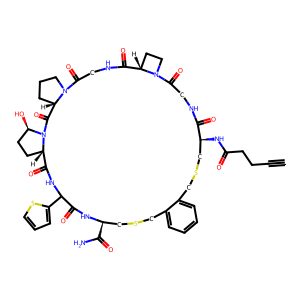

In [ ]:
test_smi = 'C#CCCC(N[C@@H](CS)C(NCC(N(CC1)[C@@H]1C(NCC(N(CCC1)[C@@H]1C(N([C@@H](CC1)C(NC(C(N[C@@H](CS)C(N)=O)=O)c2ccc[s]2)=O)[C@@H]1O)=O)=O)=O)=O)=O)=O'
macro = macrocyclize(test_smi, "C1=CC=C(C(=C1)CBr)CBr") # Added linker_smiles
if macro:
    print("Stapled Macrocycle SMILES:", Chem.MolToSmiles(macro, True))
    display(Draw.MolToImage(macro, size=(300,300)))
else:
    print("❗ No macrocycle formed. Check your SMILES have exactly two free –SH groups.")


In [ ]:
pep_path = DATA_ROOT / "libraries" / "Smiles.smi"

dibromo_xylene_linkers = [
    ("o_dibromoxylene", "C1=CC=C(C(=C1)CBr)CBr"),
    # ("m_dibromoxylene", "BrCc1cc(CBr)ccc1"),
    # ("p_dibromoxylene", "BrCc1ccc(CBr)cc1"),
   #("dibromo_pyridine", "BrCc1cccc(CBr)n1"),
   #("trans_1_4_dibromo_2_butene", "BrCC=CCBr"),
   #("2_6_bis_bromomethyl_naphthalene","BrCc1ccc2cc(CBr)ccc2c1"),
   #("3_4_bis_bromomethyl_furan",      "BrCc1oc(CBr)cc1"),
   #("2_3_bis_bromomethyl_quinoxaline","BrCc1nc2ccccc2nc1CBr"),
]
for tag, linker in dibromo_xylene_linkers:
    out_path = OUTPUT_ROOT / "csv" / f"Monomer_library_20251218_{tag}.txt"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    n_in = n_ok = 0
    with open(pep_path) as inf, open(out_path, 'w') as outf:
        outf.write("smiles\n")
        for line in inf:
            smi = line.strip()
            if not smi: continue
            n_in += 1
            m = macrocyclize(smi, linker)
            if m:
                outf.write(Chem.MolToSmiles(m, True) + '\n')
                n_ok += 1
    print(f"✅ {tag}: wrote {n_ok}/{n_in} -> {out_path}")